# Structural Analysis of the Interface

description... Gliederung??

## Import Statements

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import os
from pymol import cmd
from collections import defaultdict, Counter 
from sklearn.preprocessing import MinMaxScaler
from Bio.SeqUtils import seq1
from Bio import SeqIO # to read sequences from a FASTA file
from Bio import pairwise2 # pairwise sequence alignments
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import matplotlib.cm as cm
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu



plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'


/opt/anaconda3/envs/pymol-env/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


## Data Preparation

### Download and Save PDB files for each checkpoint

In [2]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [3]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [4]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [5]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

### Extract and Clean Antibody-Checkpoint Associations

In [6]:
l = ['CTLA-4', 'TIM3', 'PD-1', 'PD-L1', 'KIR', 'LAG3']

cp_cout_df = pd.DataFrame(index = l)

for item in l:
    count = shuffled_df[shuffled_df['compound'].str.contains(item, na=False)].shape[0]
    cp_cout_df.loc[item, 'count'] = count

cp_cout_df = cp_cout_df.reset_index()
cp_cout_df.columns = ['checkpoint', 'count'] 

In [7]:
# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_96428/60524799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_96428/60524799.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
0,IPILIMUMAB,CTLA-4,7su0,H,L,C
1,IPILIMUMAB,CTLA-4,5xj3,G,H,I
3,TISLELIZUMAB,PD-1,7cgw,H,L,P
4,IPILIMUMAB,CTLA-4,9dq4,H,L,A
5,NIVOLUMAB,PD-1,5ggr,H,L,Z
6,IPILIMUMAB,CTLA-4,5xj3,D,E,F
9,SASANLIMAB,PD-1,6xkr,H,L,P
10,CEMIPLIMAB,PD-1,8gy5,A,B,Q
11,ATEZOLIZUMAB,PD-L1,5x8l,J,O,E
15,PEMBROLIZUMAB,PD-1,5b8c,H,G,I


In [8]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()
#shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

# with open('pdb_list.txt', 'w') as f:
#     for pdb in pdb_list:
#         f.write(pdb + '\n')

In [9]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['7su0', 'H', 'L', 'C'],
 ['5xj3', 'G', 'H', 'I'],
 ['7cgw', 'H', 'L', 'P'],
 ['9dq4', 'H', 'L', 'A'],
 ['5ggr', 'H', 'L', 'Z'],
 ['5xj3', 'D', 'E', 'F'],
 ['6xkr', 'H', 'L', 'P'],
 ['8gy5', 'A', 'B', 'Q'],
 ['5x8l', 'J', 'O', 'E'],
 ['5b8c', 'H', 'G', 'I'],
 ['5xxy', 'H', 'L', 'A'],
 ['8gy5', 'H', 'L', 'P'],
 ['7bxa', 'H', 'L', 'P'],
 ['6k0y', 'A', 'B', 'C'],
 ['5ggs', 'C', 'D', 'Y'],
 ['7su1', 'H', 'L', 'C'],
 ['6txz', 'H', 'L', 'A'],
 ['7cu5', 'A', 'A', 'Q'],
 ['5ggs', 'A', 'B', 'Z'],
 ['5x8l', 'F', 'K', 'A'],
 ['5tru', 'h', 'l', 'c'],
 ['5b8c', 'B', 'A', 'C'],
 ['7wvm', 'C', 'D', 'F'],
 ['7cgw', 'A', 'B', 'C'],
 ['7su0', 'I', 'M', 'D'],
 ['6txz', 'J', 'N', 'C'],
 ['9dq3', 'H', 'L', 'C'],
 ['5ggv', 'H', 'L', 'Y'],
 ['5b8c', 'K', 'J', 'L'],
 ['5x8m', 'B', 'C', 'A'],
 ['6txz', 'K', 'O', 'D'],
 ['5xj3', 'A', 'B', 'C'],
 ['5x8l', 'H', 'M', 'C'],
 ['6txz', 'I', 'M', 'B'],
 ['5wt9', 'H', 'L', 'G'],
 ['5jxe', 'D', 'C', 'B'],
 ['5x8l', 'S', 'N', 'D'],
 ['5x8l', 'G', 'L', 'B'],
 ['7wsl', 'H

## Structural Feature Analysis 

### Surface Area, Hydrogen-Bonds and Saltbridges Extraction

In [10]:
# results = []
# section = 'paratope' 

# root_folder = "structures"
# cutoff_distance = 5.0  # in Å distance
# hbond_cutoff = 3.5  # in Å distance for hydrogen bonds
# salt_cutoff = 4.0  # in Å distance for salt bridges

# # Ensure extracted_list is defined
# if 'extracted_list' not in locals():
#     extracted_list = []  # Replace with actual data if available

# # Extracted list: [pdb_id, H_chain, L_chain, antigen_chain]

# # Loop over each chain combination from the extracted list
# for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
#     pdb_path = None
#     for dirpath, _, filenames in os.walk(root_folder):
#         for file in filenames:
#             if file.lower() == f"{pdb_id.lower()}.pdb":
#                 pdb_path = os.path.join(dirpath, file)
#                 break
#         if pdb_path:
#             break

#     if not pdb_path:
#         print(f"Skipping {pdb_id}: PDB file not found")
#         continue
#     else:
#         print(f"Processing {pdb_id}...")

#         cmd.reinitialize()
#         cmd.bg_color("white")
#         cmd.load(pdb_path)

#         # Selections
#         cmd.select("antibody", f"chain {h_chain}+{l_chain}")
#         cmd.select("antigen", f"chain {ag_chain}")
#         if section == 'paratope':
#             cmd.select(f"{section}", f"antibody within {cutoff_distance} of antigen")
#         else:
#             cmd.select(f"{section}", f"antigen within {cutoff_distance} of antibody")
#         # Color antibody chains 
#         cmd.color("marine", f"chain {h_chain}")
#         cmd.color("skyblue", f"chain {l_chain}")

#         # Color antigen chain 
#         cmd.color("salmon", "antigen")

#         # Highlight paratope/epitope
#         cmd.color("yellow", f"{section}")

#         # Surface area
#         paratope_area = cmd.get_area(f"{section}")
#         print(f" Epitope surface area: {paratope_area:.2f} Å²")

#         # Hydrogen bonds
#         hbonds = cmd.find_pairs("antibody", "antigen", mode=1, cutoff=hbond_cutoff)
#         num_hbonds = len(hbonds)
#         print(f"Found {num_hbonds} hydrogen bonds at the interface.")

#         # salt bridges 
#         # antibody acidic O  → antigen basic N
#         cmd.select("acidic_ab", f"chain {h_chain}+{l_chain} and resn ASP+GLU "
#                                 "and name OD1+OD2+OE1+OE2")
#         cmd.select("basic_ag",  f"chain {ag_chain} and resn LYS+ARG+HIS "
#                                 "and name NZ+NH1+NH2+ND1+NE2")
#         sb1 = cmd.find_pairs("acidic_ab", "basic_ag", cutoff=salt_cutoff, mode=1)

#         # antigen acidic O → antibody basic N
#         cmd.select("acidic_ag", f"chain {ag_chain} and resn ASP+GLU "
#                                 "and name OD1+OD2+OE1+OE2")
#         cmd.select("basic_ab",  f"chain {h_chain}+{l_chain} and resn LYS+ARG+HIS "
#                                 "and name NZ+NH1+NH2+ND1+NE2")
#         sb2 = cmd.find_pairs("acidic_ag", "basic_ab", cutoff=salt_cutoff, mode=1)

#         # cleanup salt-bridge selections
#         for sel in ("acidic_ab","basic_ag","acidic_ag","basic_ab"):
#             cmd.delete(sel)

#         num_salt_bridges = len(sb1) + len(sb2)
#         print(f"   ➤ Salt bridges: {num_salt_bridges}")

#         # save session 
#         session_out = os.path.join(dirpath, f"{pdb_id}_{section}.pse")
#         cmd.save(session_out)

#         # collect results 
#         results.append({
#             "pdb_id":              pdb_id,
#             "H_chain":             h_chain,
#             "L_chain":             l_chain,
#             "antigen_chain":       ag_chain,
#             f"{section}_area":       paratope_area,
#             "num_hydrogen_bonds":  num_hbonds,
#             "num_salt_bridges":    num_salt_bridges,
#             "folder":              os.path.basename(dirpath)
#         })

# # Save to CSV
# df_struc_info = pd.DataFrame(results)

# # Save results to CSV 
# df_struc_info = pd.DataFrame(results)
# df_struc_info.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_surface_hbonds_salt_bridges_summary.csv", index=False)

# #print(f"Results saved to '{section}_surface_hbonds_salt_bridges_summary.csv'")

In [11]:
# import os
# import pandas as pd
# from pymol import cmd

# results = []
# section = 'paratope' 

# root_folder = "structures"
# cutoff_distance = 5.0  # Å distance for interface selection
# hbond_cutoff = 3.5     # Å cutoff for hydrogen bonds
# salt_cutoff = 4.0      # Å cutoff for salt bridges
# bsa_threshold = 0.1    # Å² minimum BSA per residue

# # Ensure extracted_list is defined
# if 'extracted_list' not in locals():
#     extracted_list = []  # Replace with your actual data: [pdb_id, H_chain, L_chain, antigen_chain]

# # Loop over each structure
# for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
#     pdb_path = None
#     for dirpath, _, filenames in os.walk(root_folder):
#         for file in filenames:
#             if file.lower() == f"{pdb_id.lower()}.pdb":
#                 pdb_path = os.path.join(dirpath, file)
#                 break
#         if pdb_path:
#             break

#     if not pdb_path:
#         print(f"Skipping {pdb_id}: PDB file not found")
#         continue
#     else:
#         print(f"\n🔄 Processing {pdb_id}...")

#         cmd.reinitialize()
#         cmd.bg_color("white")
#         cmd.load(pdb_path)

#         # Define selections
#         cmd.select("antibody", f"chain {h_chain}+{l_chain}")
#         cmd.select("antigen", f"chain {ag_chain}")
#         cmd.select("paratope", f"chain {h_chain}+{l_chain} within {cutoff_distance} of chain {ag_chain}")

#         # Per-residue BSA and filtered H-bonds
#         buried_residues = []
#         if cmd.count_atoms(f"{section}") == 0:
#             print(" No atoms, skipping BSA analysis")
#             num_hbonds_filtered = 0
#         else:
#             {section}_residues = set()
#             model = cmd.get_model(f"{section}")
#             for atom in model.atom:
#                 {section}_residues.add((atom.chain, atom.resi))

#             for chain, resi in {section}_residues:
#                 resid_sel = f"(chain {chain} and resi {resi})"
#                 try:
#                     # SASA without antigen
#                     # Create a temporary antibody-only object
#                     cmd.create("ab_only", f"chain {h_chain}+{l_chain}")
#                     cmd.select("res_in_ab_only", f"ab_only and chain {chain} and resi {resi}")

#                     cmd.get_area("res_in_ab_only", load_b=1)
#                     sasa_free = sum([a.b for a in cmd.get_model("res_in_ab_only").atom])

#                     # Clean up
#                     cmd.delete("ab_only")
#                     cmd.delete("res_in_ab_only")

#                     # SASA in complex
#                     cmd.get_area(resid_sel, load_b=1)
#                     sasa_complex = sum([a.b for a in cmd.get_model(resid_sel).atom])
#                     bsa = sasa_free - sasa_complex

#                     print(f"   Residue {chain}:{resi} — SASA_free={sasa_free:.2f}, SASA_complex={sasa_complex:.2f}, BSA={bsa:.2f}")

#                     if bsa > bsa_threshold:
#                         buried_residues.append((chain, resi))
#                 except Exception as e:
#                     print(f"⚠️ Error for residue {chain}:{resi} → {e}")
#                     continue

#             if buried_residues:
#                 buried_sel_str = " or ".join([f"(chain {c} and resi {r})" for c, r in buried_residues])
#                 cmd.select(f"buried_{section}", buried_sel_str)

#                 # H-bonds from buried paratope residues
#                 hbonds_filtered = cmd.find_pairs(f"buried_{section}", "antigen", mode=1, cutoff=hbond_cutoff)
#                 num_hbonds_filtered = len(hbonds_filtered)
#                 print(f"   ➤ H-bonds (buried only): {num_hbonds_filtered}")
#             else:
#                 print("   ➤ No residues exceeded BSA threshold.")
#                 num_hbonds_filtered = 0

#         # Surface area of full paratope (in complex)
#         buried_paratope_area = cmd.get_area(f"{section}_paratope")
#         {section}_area = cmd.get_area(f"{section}")

#         print(f" {section} SASA in complex: {{section}_area:.2f} Å²")

#         # Hydrogen bonds (all)
#         hbonds = cmd.find_pairs("antibody", "antigen", mode=1, cutoff=hbond_cutoff)
#         num_hbonds = len(hbonds)
#         print(f"   ➤ Total H-bonds (full interface): {num_hbonds}")

#         # Salt bridges
#         # Skip if no buried residues
#         if buried_residues:
#             cmd.select("acidic_buried", f"buried_{section} and resn ASP+GLU and name OD1+OD2+OE1+OE2")
#             cmd.select("basic_ag", f"chain {ag_chain} and resn LYS+ARG+HIS and name NZ+NH1+NH2+ND1+NE2")
#             sb1 = cmd.find_pairs("acidic_buried", "basic_ag", cutoff=salt_cutoff, mode=1)

#             cmd.select("acidic_ag", f"chain {ag_chain} and resn ASP+GLU and name OD1+OD2+OE1+OE2")
#             cmd.select("basic_buried", f"buried_{section} and resn LYS+ARG+HIS and name NZ+NH1+NH2+ND1+NE2")
#             sb2 = cmd.find_pairs("acidic_ag", "basic_buried", cutoff=salt_cutoff, mode=1)

#             for sel in ("acidic_buried", "basic_ag", "acidic_ag", "basic_buried"):
#                 cmd.delete(sel)

#             num_salt_bridges = len(sb1) + len(sb2)
#             print(f"   ➤ Salt bridges (buried {section} only): {num_salt_bridges}")
#         else:
#             num_salt_bridges = 0
#             print(f"   ➤ Salt bridges skipped (no buried {section})")

#         # Save PyMOL session
#         session_out = os.path.join(dirpath, f"{pdb_id}_{section}.pse")
#         cmd.save(session_out)

#         # Collect results
#         results.append({
#             "pdb_id": pdb_id,
#             "H_chain": h_chain,
#             "L_chain": l_chain,
#             "antigen_chain": ag_chain,
#             f"{section}_area": {section}_area,
#             f"buried_{section}_area": buried_{section}_area,
#             "num_hydrogen_bonds": num_hbonds,
#             "num_filtered_hbonds": num_hbonds_filtered,
#             "num_salt_bridges": num_salt_bridges,
#             "folder": os.path.basename(dirpath)
#         })

# # Save all results
# df_struc_info = pd.DataFrame(results)
# output_dir = f"data/structural_analysis/{section.capitalize()}"
# os.makedirs(output_dir, exist_ok=True)
# output_file = os.path.join(output_dir, f"{section}_hbonds_salt_bridges_summary.csv")
# df_struc_info.to_csv(output_file, index=False)

# print(f"\n Results saved to '{output_file}'")

In [12]:
section = 'epitope'  # ← Alternativ: 'epitope'
root_folder = "structures"
cutoff_distance = 5.0
hbond_cutoff = 3.5
salt_cutoff = 4.0
bsa_threshold = 0.1

results = []

# Define interacting partners based on section
def get_partner_chains(h_chain, l_chain, ag_chain, section):
    if section == 'paratope':
        source_chain = f"{h_chain}+{l_chain}"
        target_chain = ag_chain
    elif section == 'epitope':
        source_chain = ag_chain
        target_chain = f"{h_chain}+{l_chain}"
    else:
        raise ValueError("Section must be 'paratope' or 'epitope'")
    return source_chain, target_chain

# Dummy placeholder if not defined
if 'extracted_list' not in locals():
    extracted_list = []

for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue

    print(f"\n Processing {pdb_id} ({section})...")
    cmd.reinitialize()
    cmd.bg_color("white")
    cmd.load(pdb_path)

    source_chain, target_chain = get_partner_chains(h_chain, l_chain, ag_chain, section)

    # Define selections
    cmd.select("source", f"chain {source_chain}")
    cmd.select("target", f"chain {target_chain}")
    cmd.select(section, f"source within {cutoff_distance} of target")

    buried_residues = []
    if cmd.count_atoms(section) == 0:
        print(" No atoms found, skipping BSA")
        num_hbonds_filtered = 0
    else:
        residue_set = set()
        model = cmd.get_model(section)
        for atom in model.atom:
            residue_set.add((atom.chain, atom.resi))

        for chain, resi in residue_set:
            resid_sel = f"(chain {chain} and resi {resi})"
            try:
                # Create source-only object (no target)
                cmd.create("source_only", f"chain {source_chain}")
                cmd.select("res_in_source_only", f"source_only and chain {chain} and resi {resi}")
                cmd.get_area("res_in_source_only", load_b=1)
                sasa_free = sum([a.b for a in cmd.get_model("res_in_source_only").atom])
                cmd.delete("source_only")
                cmd.delete("res_in_source_only")

                # SASA in complex
                cmd.get_area(resid_sel, load_b=1)
                sasa_complex = sum([a.b for a in cmd.get_model(resid_sel).atom])
                bsa = sasa_free - sasa_complex

                print(f"   Residue {chain}:{resi} — BSA={bsa:.2f}")
                if bsa > bsa_threshold:
                    buried_residues.append((chain, resi))

            except Exception as e:
                print(f" Error {chain}:{resi} → {e}")
                continue

        if buried_residues:
            buried_sel = " or ".join([f"(chain {c} and resi {r})" for c, r in buried_residues])
            cmd.select(f"buried_{section}", buried_sel)

            # Filtered H-bonds
            hbonds_filtered = cmd.find_pairs(f"buried_{section}", "target", mode=1, cutoff=hbond_cutoff)
            num_hbonds_filtered = len(hbonds_filtered)
            print(f" Filtered H-bonds: {num_hbonds_filtered}")
        else:
            print(" No buried residues found.")
            num_hbonds_filtered = 0

    # SASA area of selections
    try:
        buried_area = cmd.get_area(f"buried_{section}")
    except:
        buried_area = 0.0
    try:
        total_area = cmd.get_area(section)
    except:
        total_area = 0.0

    print(f" {section.capitalize()} SASA: {total_area:.2f} Å²")

    # Salt bridges from buried residues only
    if buried_residues:
        cmd.select("acidic_buried", f"buried_{section} and resn ASP+GLU and name OD1+OD2+OE1+OE2")
        cmd.select("basic_target", f"target and resn LYS+ARG+HIS and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_buried", "basic_target", cutoff=salt_cutoff, mode=1)

        cmd.select("acidic_target", f"target and resn ASP+GLU and name OD1+OD2+OE1+OE2")
        cmd.select("basic_buried", f"buried_{section} and resn LYS+ARG+HIS and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_target", "basic_buried", cutoff=salt_cutoff, mode=1)

        for sel in ("acidic_buried", "basic_target", "acidic_target", "basic_buried"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f" Salt bridges (buried): {num_salt_bridges}")
    else:
        num_salt_bridges = 0
        print(f" Salt bridges skipped")

    # Save session
    session_out = os.path.join(dirpath, f"{pdb_id}_{section}.pse")
    cmd.save(session_out)

    # Save result
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        f"{section}_area": total_area,
        f"buried_{section}_area": buried_area,
        # "num_hydrogen_bonds": num_hbonds,
        "num_filtered_hbonds": num_hbonds_filtered,
        "num_salt_bridges": num_salt_bridges,
        "folder": os.path.basename(dirpath)
    })

# Export results
output_dir = f"data/structural_analysis/{section.capitalize()}"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"{section}_hbonds_salt_bridges_summary.csv")
df = pd.DataFrame(results)
df.to_csv(output_file, index=False)
print(f"\n Results saved to '{output_file}'")



 Processing 7su0 (epitope)...
   Residue C:37 — BSA=0.00
   Residue C:97 — BSA=0.00
   Residue C:103 — BSA=0.00
   Residue C:106 — BSA=3.45
   Residue C:93 — BSA=0.00
   Residue C:108 — BSA=0.83
   Residue C:48 — BSA=0.00
   Residue C:102 — BSA=0.00
   Residue C:35 — BSA=0.00
   Residue C:3 — BSA=3.25
   Residue C:95 — BSA=1.27
   Residue C:101 — BSA=0.00
   Residue C:2 — BSA=0.00
   Residue C:5 — BSA=0.00
   Residue C:46 — BSA=0.00
   Residue C:41 — BSA=0.00
   Residue C:99 — BSA=4.08
   Residue C:100 — BSA=0.00
   Residue C:105 — BSA=0.00
   Residue C:107 — BSA=0.00
   Residue C:4 — BSA=0.00
   Residue C:33 — BSA=1.23
   Residue C:104 — BSA=0.14
   Residue C:98 — BSA=0.00
   Residue C:39 — BSA=0.00
   Residue C:47 — BSA=0.00
 Filtered H-bonds: 12
 Epitope SASA: 1579.15 Å²
 Salt bridges (buried): 0

 Processing 5xj3 (epitope)...
   Residue I:136 — BSA=0.00
   Residue I:134 — BSA=3.32
   Residue I:74 — BSA=0.00
   Residue I:132 — BSA=2.30
   Residue I:137 — BSA=0.00
   Residue I:72 — 

In [13]:
df_struc_info = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv")
# print(df_struc_info['pdb_id'].value_counts())
df_struc_info

,pdb_id,H_chain,L_chain,antigen_chain,epitope_area,buried_epitope_area,num_filtered_hbonds,num_salt_bridges,folder
0,7su0,H,L,C,1579.147217,831.052795,12,0,ctla4
1,5xj3,G,H,I,1317.388306,725.980042,9,0,ctla4
2,7cgw,H,L,P,1545.606567,699.224426,19,2,pd1
3,9dq4,H,L,A,2228.426514,1725.535645,169,3,ctla4
4,5ggr,H,L,Z,1006.088806,715.591370,30,0,pd1
5,5xj3,D,E,F,1529.390869,1003.261108,15,0,ctla4
6,6xkr,H,L,P,1621.897705,720.337158,11,0,pd1
7,8gy5,A,B,Q,1015.824890,498.153687,13,0,pd1
8,5x8l,J,O,E,1705.828735,1175.162231,27,0,pdl1
9,5b8c,H,G,I,1523.636963,1030.029907,21,0,pd1


### Visualizing Structural Features

#### barplot - surface area 

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

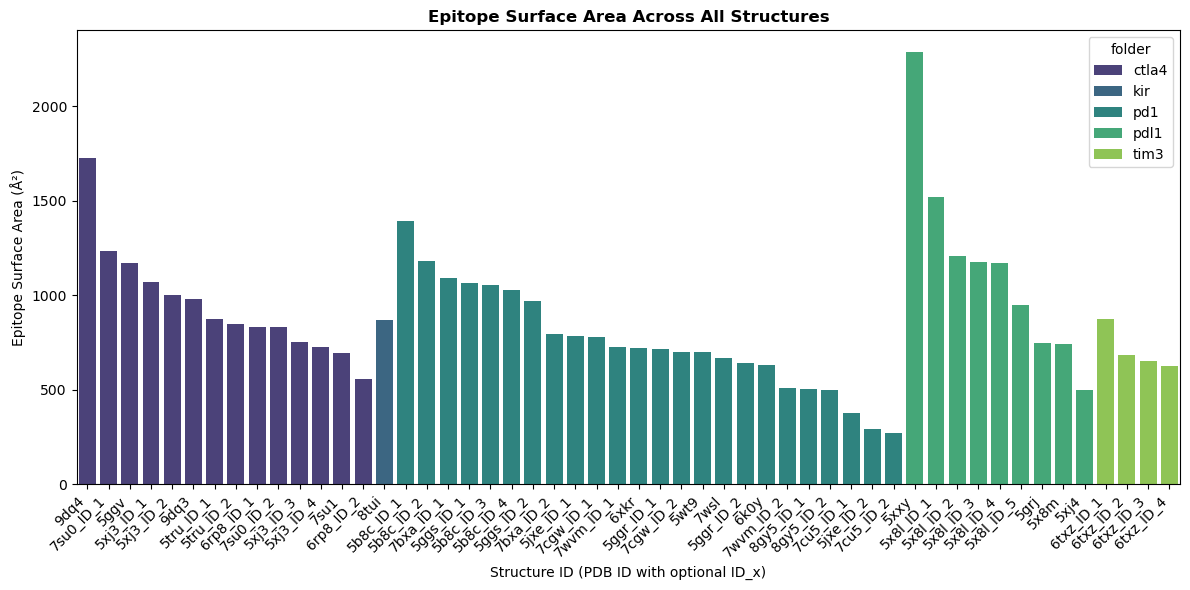

In [14]:
area = f"buried_{section}_area"
# Sort as before
df_sorted = df_struc_info.sort_values(by=["folder", area], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y=f"buried_{section}_area", hue="folder", dodge=False, palette="viridis")

plt.title(f"{section.capitalize()} Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel(f"{section.capitalize()} Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



#### Scatter Plot - Hydrogen Bonds vs Surface Area

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

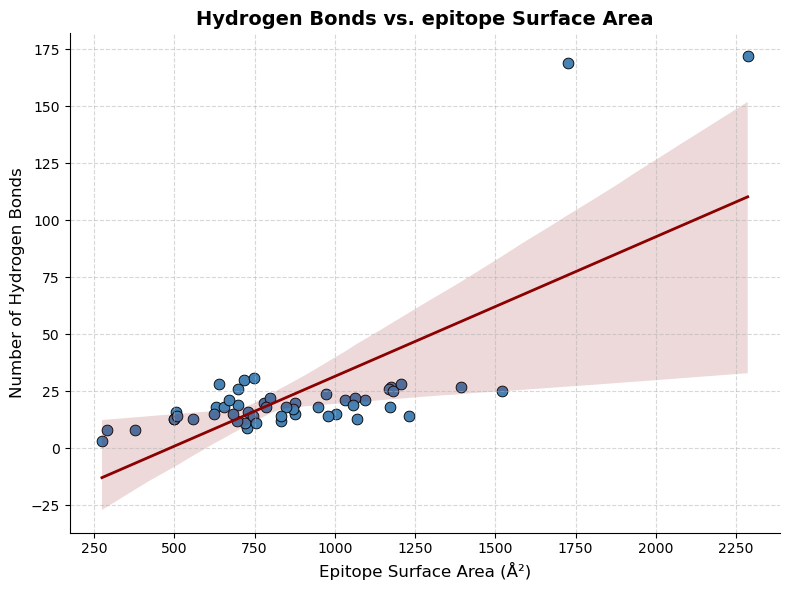

In [15]:
df_struc_info = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv")

plt.figure(figsize=(8, 6))

# Scatterplot
sns.scatterplot(
    data=df_struc_info,
    x=f"buried_{section}_area",
    y="num_filtered_hbonds",
    s=60,
    color="steelblue",
    edgecolor="black"
)

# Regression line
sns.regplot(
    data=df_struc_info,
    x=f"buried_{section}_area",
    y="num_filtered_hbonds",
    scatter=False,
    color="darkred",
    line_kws={'linewidth': 2}
)

# Styling
plt.title(f"Hydrogen Bonds vs. {section} Surface Area", fontsize=14, fontweight="bold")
plt.xlabel(f"{section.capitalize()} Surface Area (Å²)", fontsize=12)
plt.ylabel("Number of Hydrogen Bonds", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()

# Save (optional)
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/hbonds_vs_surface_area_{section}.pdf", bbox_inches='tight')
plt.show()


#### Barplot - Hydrogen Bonds per PDB ID

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

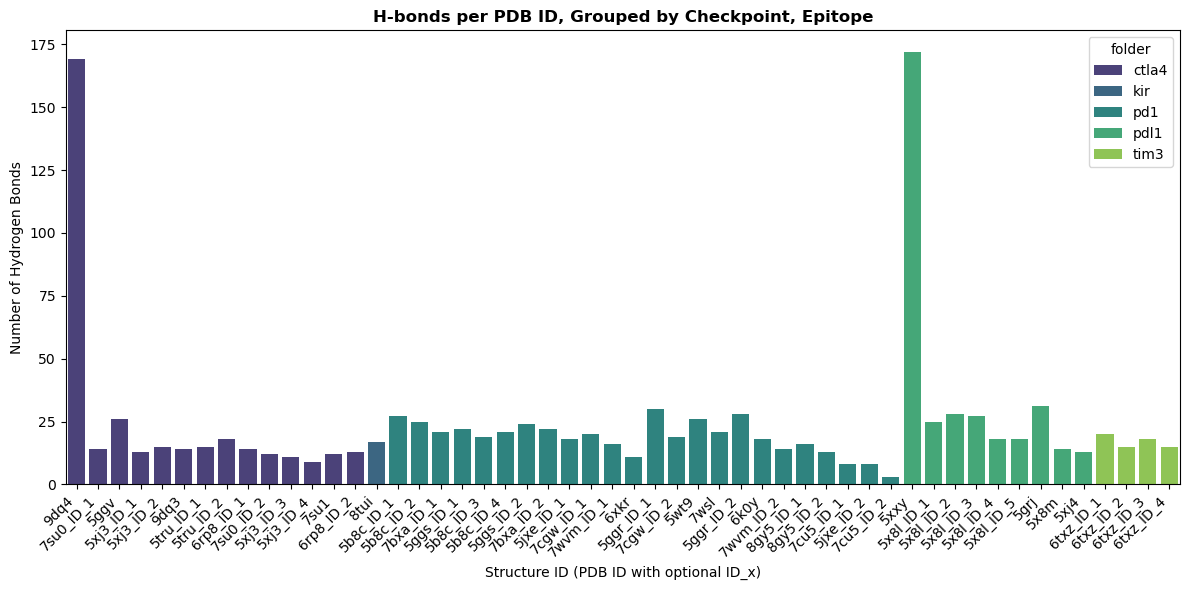

In [16]:
df_sorted_h = df_struc_info.sort_values(by=["folder", "num_filtered_hbonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_h["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_h["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_h["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_filtered_hbonds", hue="folder", dodge=False, palette="viridis")

plt.title(f"H-bonds per PDB ID, Grouped by Checkpoint, {section.capitalize()}")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

#### Barplot - Salt Bridges per PDB ID

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

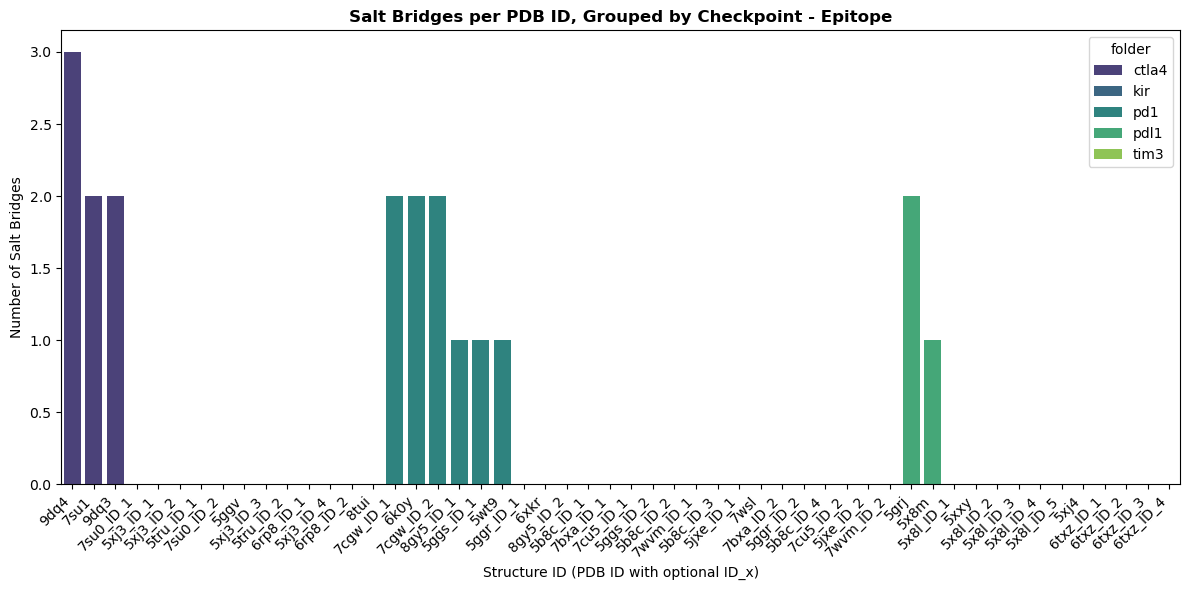

In [17]:

df_sorted_s = df_struc_info.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_s["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_s["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_s["structure_id"] = structure_ids


# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_s, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title(f"Salt Bridges per PDB ID, Grouped by Checkpoint - {section.capitalize()}")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section.capitalize()}/{section}_salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 



## Binding Score 

In [18]:

#normalizing with MinMax
scaler = MinMaxScaler()
df = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_hbonds_salt_bridges_summary.csv")
features = df[["num_filtered_hbonds", "num_salt_bridges", f"buried_{section}_area"]].copy()
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  

# Create a binding strength score
weights = {
    "num_filtered_hbonds": 0.4,
    "num_salt_bridges": 0.4,
    f"buried_{section}_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_filtered_hbonds"] * weights["num_filtered_hbonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm[f"buried_{section}_area"] * weights[f"buried_{section}_area"]
)

In [19]:
# Sort the dataframe
df_sorted_bs = df_norm.sort_values(
    by=["binding_score", "num_filtered_hbonds", "num_salt_bridges", f"buried_{section}_area"],
    ascending=[False, False, False, False]  
).copy()
# Count appearances
id_frequencies = Counter(df_sorted_bs["pdb_id"])
id_tracker = defaultdict(int)

# Build unique structure IDs
structure_ids = []
for pdb_id in df_sorted_bs["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# Add to DataFrame
df_sorted_bs["structure_id"] = structure_ids

### barplot - Binding Score Composition per PDB ID

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_96428/2423592292.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font f

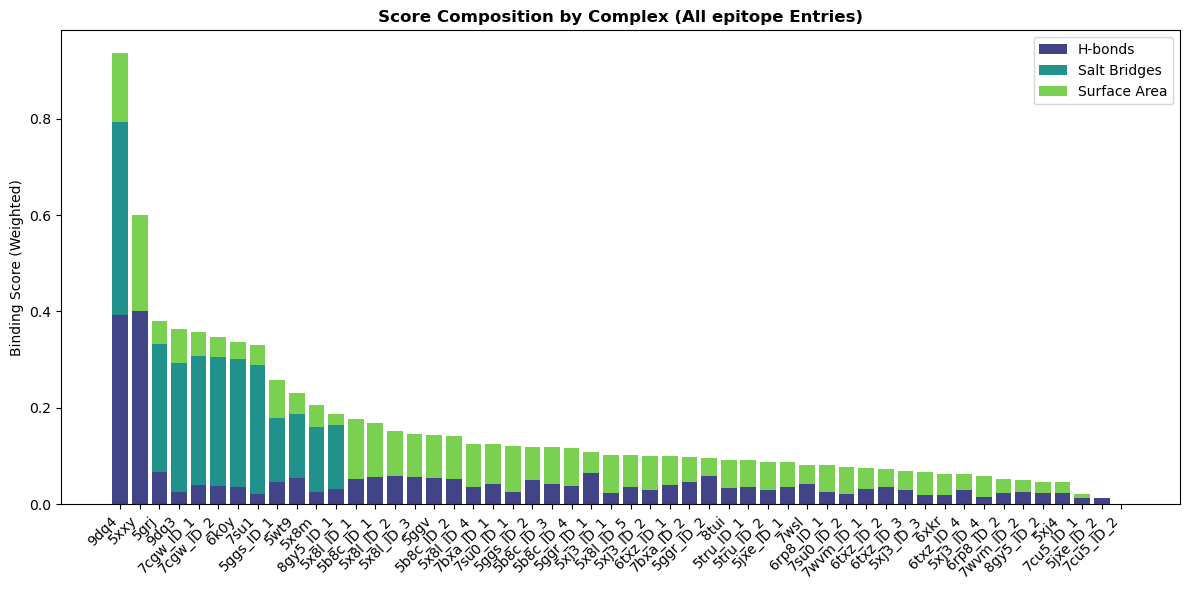

In [20]:
# Sort by binding score again
top = df_sorted_bs.sort_values("binding_score", ascending=False)

# Use viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_filtered_hbonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_filtered_hbonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top[f"buried_{section}_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_filtered_hbonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title(f"Score Composition by Complex (All {section} Entries)")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()




## Sequence Analysis

### Sequences Extraction

In [ ]:
# Input settings
root_folder = "structures"
cutoff_distance = 5.0 
section = 'epitope'
bsa_threshold = 0.1  
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Format: [pdb_id, H_chain, L_chain, antigen_chain]

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    if section == 'paratope':
        cmd.select(section, f"antibody within {cutoff_distance} of antigen")
        interaction_chain = f"{h_chain}+{l_chain}"
    else:
        cmd.select(section, f"antigen within {cutoff_distance} of antibody")
        interaction_chain = ag_chain

    # Extract buried residues
    model = cmd.get_model(section)
    seen = set()
    buried_residues = []

    for atom in model.atom:
        res_id = (atom.chain, atom.resi, atom.resn)
        if res_id in seen or atom.resn == "HOH":
            continue
        seen.add(res_id)

        chain, resi, resn = res_id
        resid_sel = f"(chain {chain} and resi {resi})"

        try:
            # SASA before interaction
            cmd.create("temp_obj", f"chain {interaction_chain}")
            cmd.select("res_free", f"temp_obj and chain {chain} and resi {resi}")
            cmd.get_area("res_free", load_b=1)
            sasa_free = sum(a.b for a in cmd.get_model("res_free").atom)
            cmd.delete("temp_obj")
            cmd.delete("res_free")

            # SASA after interaction (in complex)
            cmd.get_area(resid_sel, load_b=1)
            sasa_complex = sum(a.b for a in cmd.get_model(resid_sel).atom)

            bsa = sasa_free - sasa_complex
            if bsa > bsa_threshold:
                buried_residues.append((int(resi), resn))
        except Exception as e:
            print(f"Error for {pdb_id} residue {chain}:{resi} → {e}")
            continue

    # Sort and convert to 1-letter sequence
    buried_residues.sort(key=lambda x: x[0])
    sequence = ''.join(seq1(resn) for _, resn in buried_residues)

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        f"{section}_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign structure_id
df_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

structure_ids = []
for pdb_id in df_seq["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID{id_tracker[pdb_id]}")

df_seq["structure_id"] = structure_ids

# Save CSV
output_dir = f"data/structural_analysis/{section.capitalize()}"
os.makedirs(output_dir, exist_ok=True)
df_seq.to_csv(f"{output_dir}/{section}_sequences_summary.csv", index=False)

# Save FASTA
with open(f"{output_dir}/{section}_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row[f'{section}_sequence']}\n")


print(f"BSA-filtered sequences saved to CSV and FASTA.")

df_sorted_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()


Processing 7su0...
Processing 5xj3...
Processing 7cgw...
Processing 9dq4...
Processing 5ggr...
Processing 5xj3...
Processing 6xkr...
Processing 8gy5...
Processing 5x8l...
Processing 5b8c...
Processing 5xxy...
Processing 8gy5...
Processing 7bxa...
Processing 6k0y...
Processing 5ggs...
Processing 7su1...
Processing 6txz...
Processing 7cu5...
Processing 5ggs...
Processing 5x8l...
Processing 5tru...
Processing 5b8c...
Processing 7wvm...
Processing 7cgw...
Processing 7su0...
Processing 6txz...
Processing 9dq3...
Processing 5ggv...
Processing 5b8c...
Processing 5x8m...
Processing 6txz...
Processing 5xj3...
Processing 5x8l...
Processing 6txz...
Processing 5wt9...
Processing 5jxe...
Processing 5x8l...
Processing 5x8l...
Processing 7wsl...
Processing 7bxa...
Processing 5ggr...
Processing 5xj4...
Processing 5b8c...
Processing 8tui...
Processing 5tru...


In [ ]:
# # # not unqiue sequences
# # # Input settings
# # root_folder = "structures"
# # cutoff_distance = 5.0 
# # section = 'paratope' 
# # results = []

# # # Ensure extracted_list is defined
# # if 'extracted_list' not in locals():
# #     extracted_list = []  # Replace with actual data

# # # Loop through all extracted entries
# # for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
# #     pdb_path = None
# #     for dirpath, _, filenames in os.walk(root_folder):
# #         for file in filenames:
# #             if file.lower() == f"{pdb_id.lower()}.pdb":
# #                 pdb_path = os.path.join(dirpath, file)
# #                 break
# #         if pdb_path:
# #             break

# #     if not pdb_path:
# #         print(f"Skipping {pdb_id}: PDB file not found")
# #         continue
# #     else:
# #         print(f"Processing {pdb_id}...")

# #     cmd.reinitialize()
# #     cmd.load(pdb_path)

# #     # Define selections
# #     cmd.select("antibody", f"chain {h_chain}+{l_chain}")
# #     cmd.select("antigen", f"chain {ag_chain}")
# #     if section == 'paratope':
# #         cmd.select(f"{section}", f"antibody within {cutoff_distance} of antigen")
# #     else:
# #         cmd.select(f"{section}", f"antigen within {cutoff_distance} of antibody")

# #     # Extract unique residues from epitope
# #     model = cmd.get_model(f"{section}")
# #     seen = set()
# #     residues = []
# #     for atom in model.atom:
# #         res_id = (atom.chain, atom.resi)
# #         if res_id not in seen:
# #             seen.add(res_id)
# #             residues.append(atom.resn)

# #     sequence = ''.join(seq1(res) for res in residues if res != "HOH")

# #     # Collect results
# #     results.append({
# #         "pdb_id": pdb_id,
# #         "H_chain": h_chain,
# #         "L_chain": l_chain,
# #         "antigen_chain": ag_chain,
# #         f"{section}_sequence": sequence,
# #         "folder": os.path.basename(dirpath)
# #     })

# # # Convert to DataFrame
# # df_seq = pd.DataFrame(results)

# # # Assign unique structure_id 
# # df_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
# # id_frequencies = Counter(df_seq["pdb_id"])
# # id_tracker = defaultdict(int)

# structure_ids = []
# for pdb_id in df_seq["pdb_id"]:
#     if id_frequencies[pdb_id] == 1:
#         structure_ids.append(pdb_id)
#     else:
#         id_tracker[pdb_id] += 1
#         structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# # df_seq["structure_id"] = structure_ids

# # # Save CSV
# df_seq.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_sequences_summary.csv", index=False)
# # #print(f"Summary table saved to '{section}_sequences_summary.csv'")

# # Save FASTA
# with open(f"data/structural_analysis/{section.capitalize()}/{section}_sequences.fasta", "w") as f:
#     for _, row in df_seq.iterrows():
#         f.write(f">{row['structure_id']}\n{row[f'{section}_sequence']}\n")

# # print(f"FASTA file saved to '{section}_sequences.fasta'")

# # # Add sequence to df_sorted

# # df_sorted_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
   

### Identiy Matrix

In [ ]:
# Load sequences
records = list(SeqIO.parse(f"data/structural_analysis/{section.capitalize()}/{section}_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df_identity.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_sequence_comparison_matrix.csv")
print(f" Sequence identity matrix saved to '{section}_sequence_comparison_matrix.csv'")
print(df_identity)


 Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
          5tru_ID1  6rp8_ID1  6rp8_ID2  5xj3_ID1  5xj3_ID2  5xj3_ID3    9dq4  \
5tru_ID1    100.00     85.71     77.78     57.14     71.43     85.71   38.46   
6rp8_ID1     85.71    100.00     77.78     57.14     71.43     85.71   30.77   
6rp8_ID2     77.78     77.78    100.00     55.56     66.67     77.78   38.46   
5xj3_ID1     57.14     57.14     55.56    100.00     83.33     71.43   30.77   
5xj3_ID2     71.43     71.43     66.67     83.33    100.00     85.71   38.46   
5xj3_ID3     85.71     85.71     77.78     71.43     85.71    100.00   38.46   
9dq4         38.46     30.77     38.46     30.77     38.46     38.46  100.00   
5tru_ID2     55.56     55.56     77.78     44.44     55.56     66.67   38.46   
5xj3_ID4     85.71     71.43     66.67     57.14     71.43     85.71   38.46   
5ggv         44.44     44.44     44.44     33.33     33.33     33.33   30.77   
9dq3         55.56     44.44     55.56     

In [ ]:
# Load sequences
records = list(SeqIO.parse(f"data/structural_analysis/{section.capitalize()}/{section}_sequences.fasta", "fasta"))

# Define PDB IDs to exclude 
# if section.lower() == "paratope":
    # excluded_ids = {"7cu5_ID_2", "5x8l_ID_2", "6txz_ID_2", "6txz_ID_3"}
# else: 
    # excluded_ids = {"5ggr_ID_2", "5b8c_ID_4", "5x8l_ID_4"}

# Filter records
# records = [rec for rec in records if rec.id not in excluded_ids]

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100
        row.append(round(identity, 2))
    matrix.append(row)

# DF
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save 
df_identity.to_csv(f"data/structural_analysis/{section.capitalize()}/{section}_sequence_comparison_matrix.csv")
print(f"Sequence identity matrix saved to '{section}_sequence_comparison_matrix.csv'")
print(df_identity)


Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
          5tru_ID1  6rp8_ID1  6rp8_ID2  5xj3_ID1  5xj3_ID2  5xj3_ID3    9dq4  \
5tru_ID1    100.00     85.71     77.78     57.14     71.43     85.71   38.46   
6rp8_ID1     85.71    100.00     77.78     57.14     71.43     85.71   30.77   
6rp8_ID2     77.78     77.78    100.00     55.56     66.67     77.78   38.46   
5xj3_ID1     57.14     57.14     55.56    100.00     83.33     71.43   30.77   
5xj3_ID2     71.43     71.43     66.67     83.33    100.00     85.71   38.46   
5xj3_ID3     85.71     85.71     77.78     71.43     85.71    100.00   38.46   
9dq4         38.46     30.77     38.46     30.77     38.46     38.46  100.00   
5tru_ID2     55.56     55.56     77.78     44.44     55.56     66.67   38.46   
5xj3_ID4     85.71     71.43     66.67     57.14     71.43     85.71   38.46   
5ggv         44.44     44.44     44.44     33.33     33.33     33.33   30.77   
9dq3         55.56     44.44     55.56     4

### Heatmap - Sequence Identity 

In [ ]:
checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), 
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID → Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    '''Get checkpoint label for a given PDB ID'''
    base_id = pdb_id.lower().split('_')[0]
    checkpoint = pdb_to_checkpoint.get(base_id)  
    return f"{checkpoint} | {pdb_id}"

df_identity = df_identity.copy()
df_identity.index = [get_checkpoint_label(p) for p in df_identity.index]
df_identity.columns = [get_checkpoint_label(p) for p in df_identity.columns]

df_identity

# annot_data = df_identity.applymap(lambda x: f"{x:.0f}")
# mask = None

# plt.figure(figsize=(24, 20))
# sns.set(style="white", font_scale=1.0)

# ax = sns.heatmap(
#     df_identity, 
#     annot=annot_data, 
#     fmt="", 
#     cmap="viridis", 
#     mask=mask,
#     square=True, 
#     linewidths=0.3, 
#     cbar_kws={"label": "Sequence Identity (%)"}
# )

# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.title(f"{section.capitalize()} Sequence Identity Matrix", fontsize=14)
# plt.tight_layout()

# plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_identity_heatmap_final.pdf", dpi=300)
# plt.show()

# print(f"Cleaned-up heatmap saved as '{section}_identity_heatmap_final.pdf'")

,CTLA-4 | 5tru_ID1,CTLA-4 | 6rp8_ID1,CTLA-4 | 6rp8_ID2,CTLA-4 | 5xj3_ID1,CTLA-4 | 5xj3_ID2,CTLA-4 | 5xj3_ID3,CTLA-4 | 9dq4,CTLA-4 | 5tru_ID2,CTLA-4 | 5xj3_ID4,CTLA-4 | 5ggv,...,PD-L1 | 5xj4,PD-L1 | 5xxy,PD-L1 | 5x8l_ID3,PD-L1 | 5x8l_ID4,PD-L1 | 5x8m,PD-L1 | 5x8l_ID5,TIM3 | 6txz_ID1,TIM3 | 6txz_ID2,TIM3 | 6txz_ID3,TIM3 | 6txz_ID4
CTLA-4 | 5tru_ID1,100.00,85.71,77.78,57.14,71.43,85.71,38.46,55.56,85.71,44.44,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,42.86,42.86,42.86
CTLA-4 | 6rp8_ID1,85.71,100.00,77.78,57.14,71.43,85.71,30.77,55.56,71.43,44.44,...,14.29,18.75,30.00,27.27,42.86,33.33,33.33,42.86,42.86,42.86
CTLA-4 | 6rp8_ID2,77.78,77.78,100.00,55.56,66.67,77.78,38.46,77.78,66.67,44.44,...,33.33,31.25,50.00,45.45,44.44,55.56,44.44,44.44,33.33,44.44
CTLA-4 | 5xj3_ID1,57.14,57.14,55.56,100.00,83.33,71.43,30.77,44.44,57.14,33.33,...,40.00,18.75,30.00,27.27,42.86,33.33,22.22,28.57,28.57,28.57
CTLA-4 | 5xj3_ID2,71.43,71.43,66.67,83.33,100.00,85.71,38.46,55.56,71.43,33.33,...,33.33,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
CTLA-4 | 5xj3_ID3,85.71,85.71,77.78,71.43,85.71,100.00,38.46,66.67,85.71,33.33,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
CTLA-4 | 9dq4,38.46,30.77,38.46,30.77,38.46,38.46,100.00,38.46,38.46,30.77,...,15.38,31.25,38.46,38.46,23.08,38.46,30.77,30.77,23.08,23.08
CTLA-4 | 5tru_ID2,55.56,55.56,77.78,44.44,55.56,66.67,38.46,100.00,55.56,44.44,...,33.33,31.25,50.00,45.45,33.33,55.56,33.33,22.22,33.33,22.22
CTLA-4 | 5xj3_ID4,85.71,71.43,66.67,57.14,71.43,85.71,38.46,55.56,100.00,33.33,...,28.57,25.00,40.00,36.36,42.86,44.44,33.33,28.57,42.86,28.57
CTLA-4 | 5ggv,44.44,44.44,44.44,33.33,33.33,33.33,30.77,44.44,33.33,100.00,...,22.22,31.25,30.00,36.36,33.33,44.44,44.44,44.44,44.44,55.56


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/295800801.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


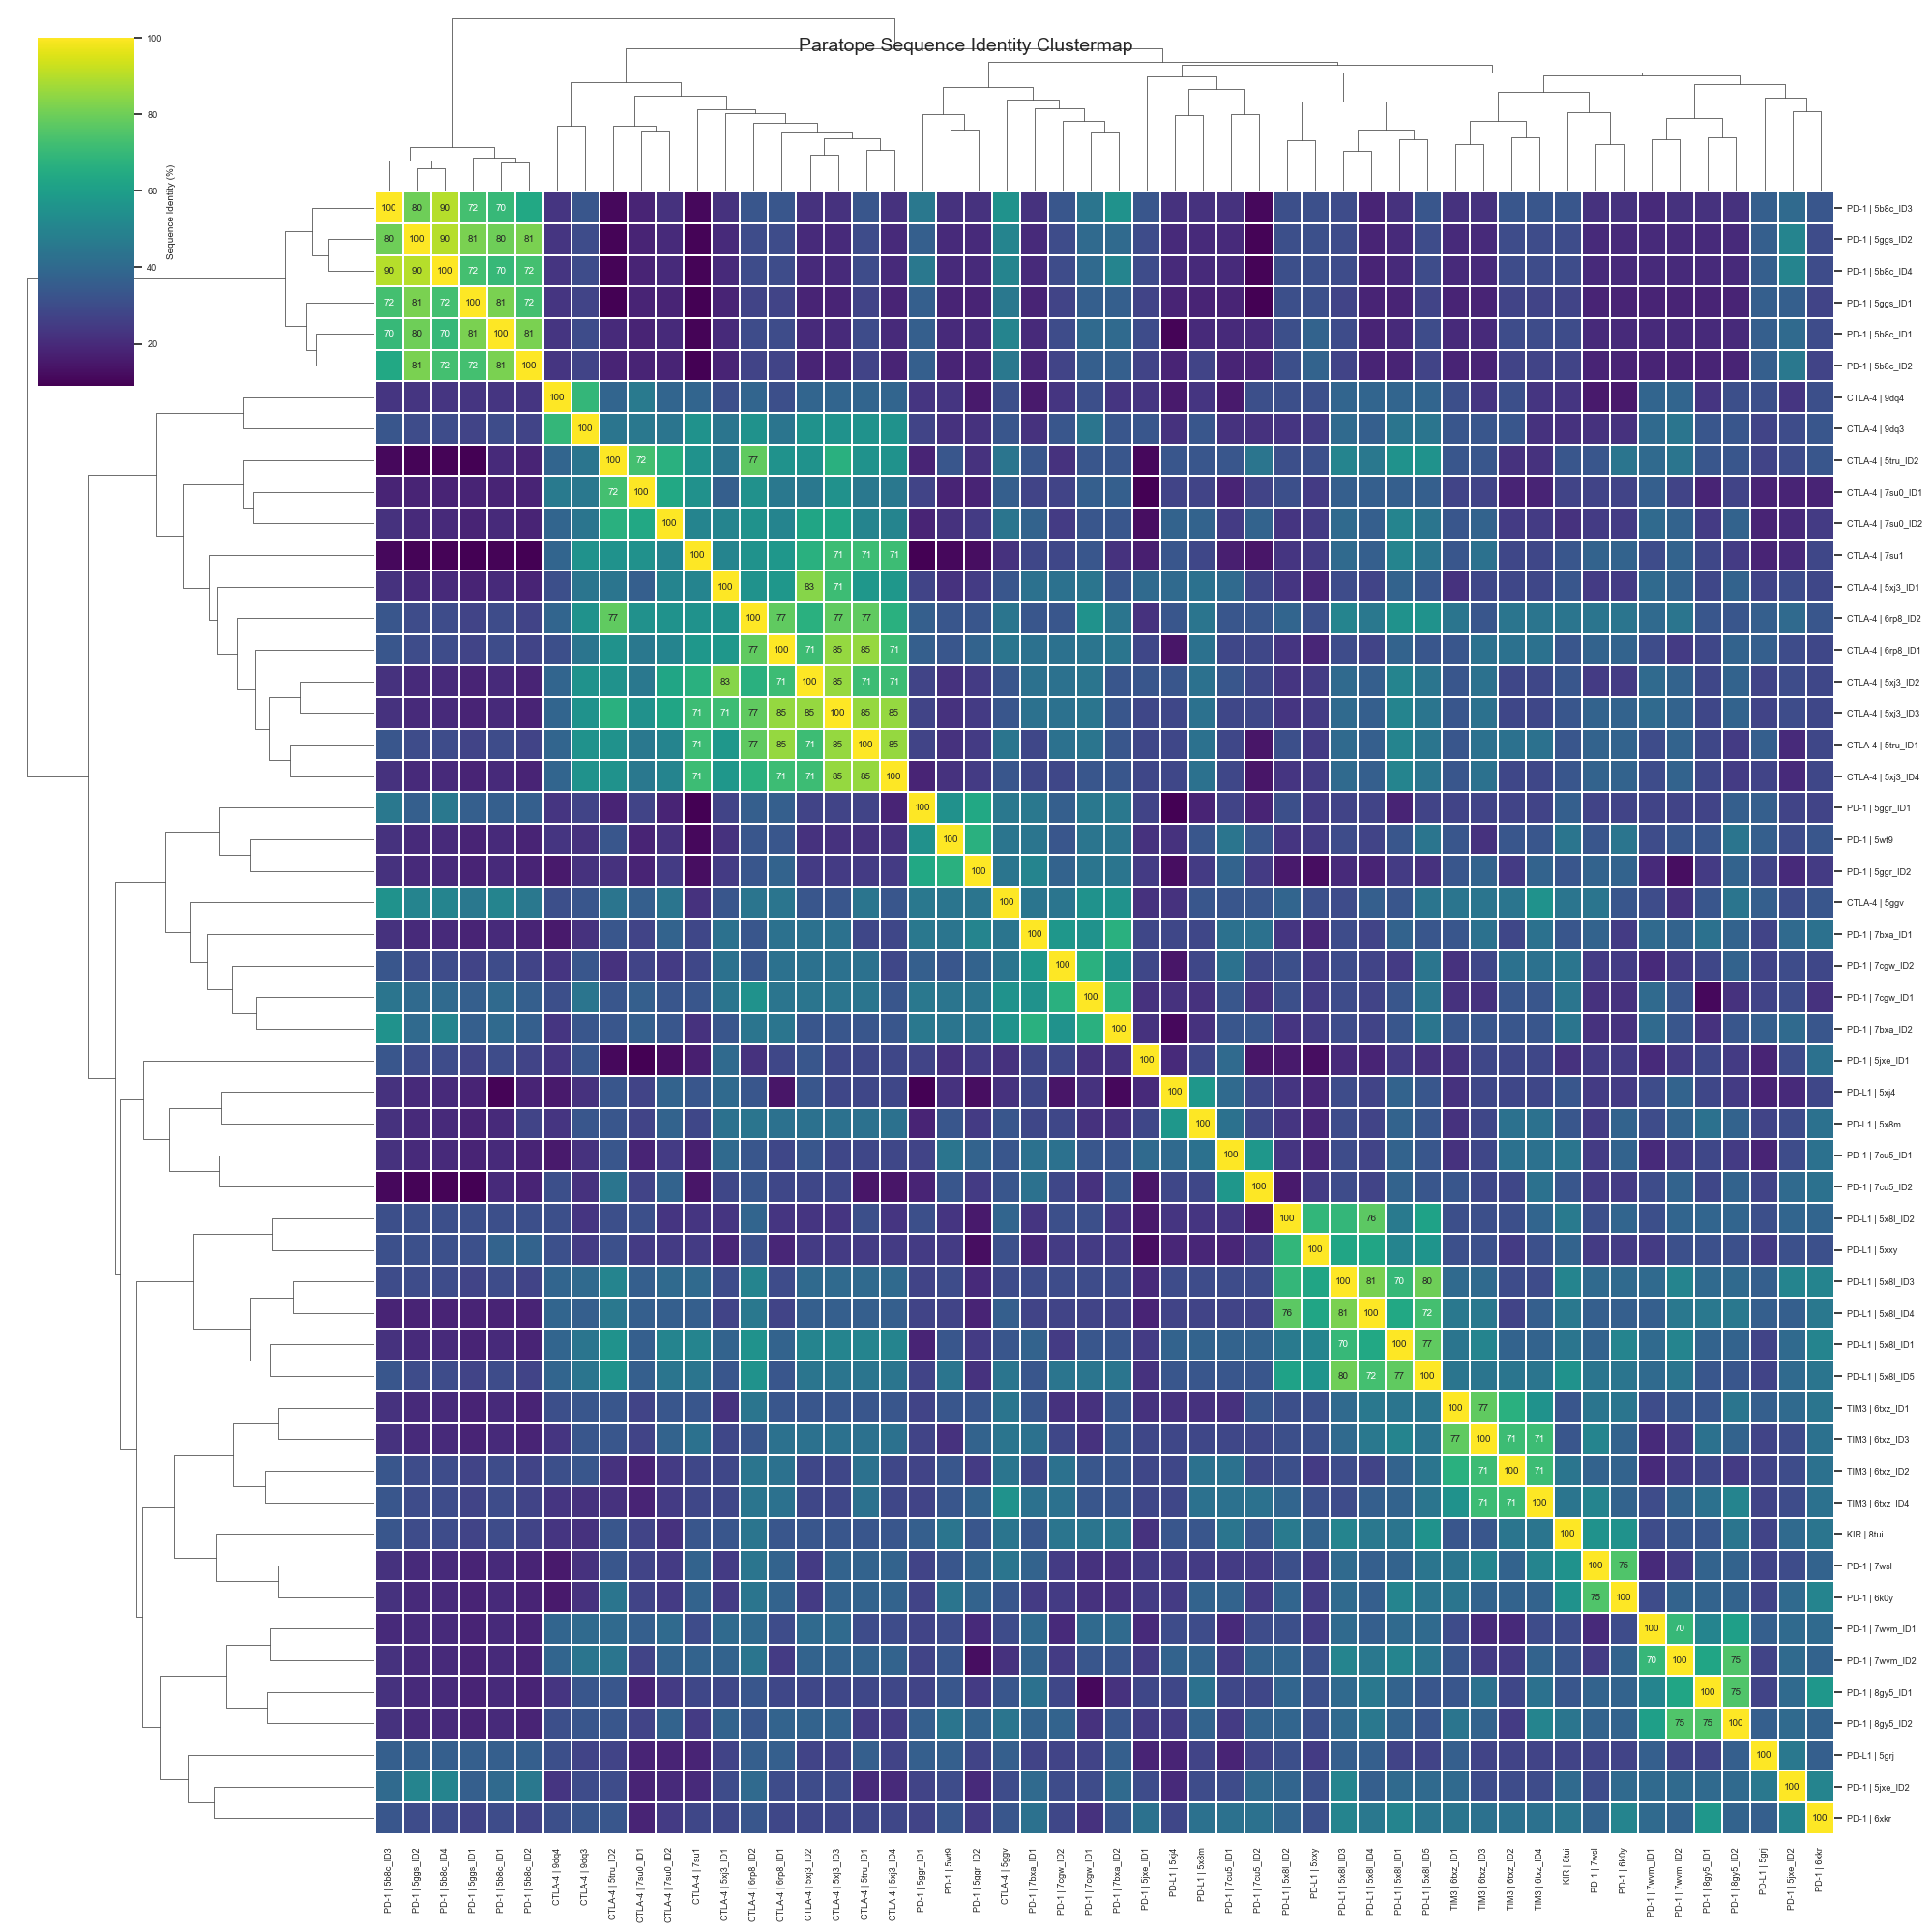

In [ ]:
# annotate only high identities
annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

# clustermap
sns.set(font_scale=0.6)  
g = sns.clustermap(
    df_identity,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={"label": "Sequence Identity (%)"},
    dendrogram_ratio=(.2, .1),  # ratio for row/col dendrograms
    xticklabels=True,
    yticklabels=True
)

#save 
g.fig.suptitle(f"{section.capitalize()} Sequence Identity Clustermap", fontsize=14)
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


### Barplot - Sequence Length per PDB ID

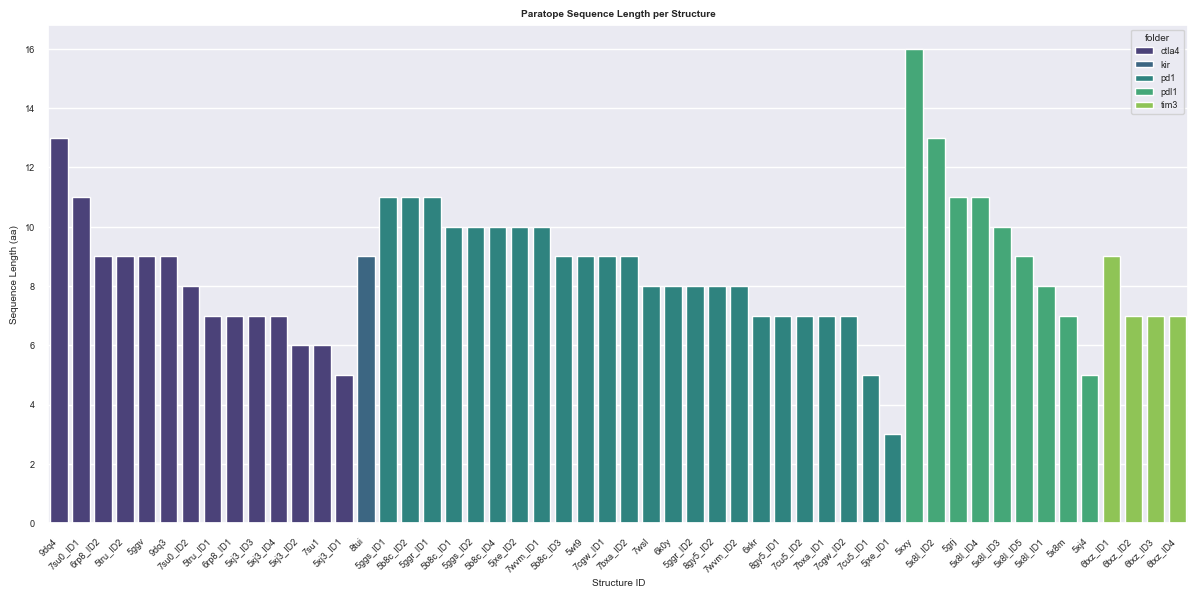

In [ ]:
# Add column with sequence length
df_seq[f"{section}_length"] = df_seq[f"{section}_sequence"].str.len()

# Sort 
df_seq_sorted_by_length = df_seq.sort_values(by=["folder", f"{section}_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted_by_length, x="structure_id", y=f"{section}_length", hue="folder", dodge=False, palette="viridis")

plt.title(f"{section.capitalize()} Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section.capitalize()}/{section}_sequence_lengths.pdf", bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
from collections import defaultdict, Counter

# 1. Load data
df_struct = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/{section}_surface_hbonds_salt_bridges_summary.csv")

# 2. Create structure_id in df_struct
id_frequencies = Counter(df_struct["pdb_id"])
id_tracker = defaultdict(int)
structure_ids = []
for pdb_id in df_struct["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}ID{id_tracker[pdb_id]}")
df_struct["structure_id"] = structure_ids

# 3. Optional: remove duplicates from df_norm if needed
df_norm = df_norm.drop_duplicates(subset="pdb_id")

# 4. Merge everything
all_df = pd.merge(df_struct, df_sorted_seq[["structure_id", f"{section}_sequence"]], on="structure_id", how="left")
all_df = pd.merge(all_df, df_norm[["pdb_id", "binding_score"]], on="pdb_id", how="left")

# 5. Save
all_df.to_csv(f"data/structural_analysis/{section.capitalize()}/structural_{section}_all_information_final.csv", index=False)

In [ ]:
all_df.rename(columns={"folder": "checkpoint"}, inplace=True)
print(all_df)

   pdb_id H_chain L_chain antigen_chain  paratope_area  buried_surface_area  \
0    5ggr       A       B             Y    1252.175903            44.011719   
1    7wvm       C       D             F    1357.874512             5.251953   
2    7cgw       H       L             P    1605.023438            41.745117   
3    9dq4       H       L             A    1897.172119           -38.039062   
4    5ggs       A       B             Z    2308.719238            42.147461   
5    5jxe       D       C             B    1563.665527            34.076172   
6    7wsl       H       L             D    2171.249756            44.034180   
7    5xxy       H       L             A    2043.012085           -40.334961   
8    7wvm       A       B             E    1319.529053             6.581055   
9    5b8c       H       G             I    2049.619141             6.833984   
10   6rp8       H       L             C    1255.458130            43.142578   
11   7cgw       A       B             C    1654.5998

## Do cluster have different binding affinities? 

In [ ]:
if section.lower() == "paratope":
    manual_clusters = {
    "Cluster 1": ["5x8m", "5xj4", "9dq3", "9dq4", "7su1", "7su0", "5xj3", "6rp8", "5tru" ],
    "Cluster 2": ["6txz"],
    "Cluster 3": ["5xB1", "5xxy"],
    "Cluster 4": ["5ggs", "5jxe", "5b8c"],
    "Cluster 5": ["7wvm", "8gy5"],
    "Cluster 6": ["7cgw", "7bxa"],
    "Cluster 7": ["5wt9", "5ggr"]
    }
else: 
    manual_clusters = {
    "Cluster 1": ["7su1", "5ggv", "9dq3", "6rp8", "5tru", "7su0", "6rp8", "5xq3"],
    "Cluster 2": ["5b8c", "5ggs", "5jxe", "7bxa", "6xkr", "7cgw", "5ggr", "5wt9", "7cu5", "8gy5", "7wsl", "6k0y", "7wym"],
    "Cluster 3": ["6txz"],
    "Cluster 4": ["5xxy", "5x8i", "5grj", "5xj4", "5x8m"],
}

# Convert manual Cluster-Dict in list 
cluster_rows = []
for cluster_name, pdb_list in manual_clusters.items():
    for pdb in pdb_list:
        cluster_rows.append({"pdb_id": pdb, "cluster": cluster_name})

# DF
cluster_df = pd.DataFrame(cluster_rows)

# 3. Merge with main df 
merged_df = cluster_df.merge(all_df[["pdb_id", "binding_score", "checkpoint"]], on="pdb_id", how="left")

print(merged_df)

   pdb_id    cluster  binding_score checkpoint
0    5x8m  Cluster 1       0.203661       pdl1
1    5xj4  Cluster 1       0.048571       pdl1
2    9dq3  Cluster 1       0.376213      ctla4
3    9dq4  Cluster 1       0.951521      ctla4
4    7su1  Cluster 1       0.313449      ctla4
5    7su0  Cluster 1       0.142831      ctla4
6    7su0  Cluster 1       0.142831      ctla4
7    5xj3  Cluster 1       0.066769      ctla4
8    5xj3  Cluster 1       0.066769      ctla4
9    5xj3  Cluster 1       0.066769      ctla4
10   5xj3  Cluster 1       0.066769      ctla4
11   6rp8  Cluster 1       0.067610      ctla4
12   6rp8  Cluster 1       0.067610      ctla4
13   5tru  Cluster 1       0.101403      ctla4
14   5tru  Cluster 1       0.101403      ctla4
15   6txz  Cluster 2       0.060186       tim3
16   6txz  Cluster 2       0.060186       tim3
17   6txz  Cluster 2       0.060186       tim3
18   6txz  Cluster 2       0.060186       tim3
19   5xB1  Cluster 3            NaN        NaN
20   5xxy  Cl

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/3831050858.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")


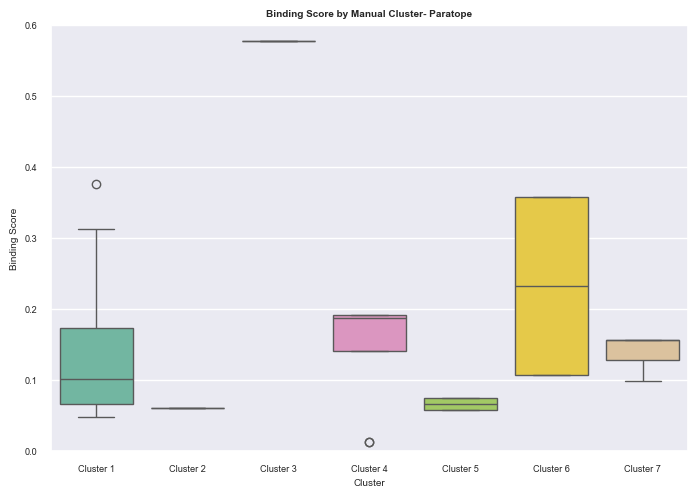

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")

plt.title(f"Binding Score by Manual Cluster- {section.capitalize()}")
plt.xlabel("Cluster")
plt.ylabel("Binding Score")
plt.tight_layout()
plt.ylim(0, 0.6)

plt.savefig(f"plots/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_binding_score_by_cluster.pdf", bbox_inches='tight')


In [ ]:
# group by cluster 
grouped_scores = [
    group["binding_score"].dropna().values
    for name, group in merged_df.groupby("cluster")
]

# Kruskal–Wallis-Test
stat, p = kruskal(*grouped_scores)

print(f"Kruskal–Wallis-Test: H = {stat:.3f}, p = {p:.4e}")


Kruskal–Wallis-Test: H = 12.970, p = 4.3516e-02


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


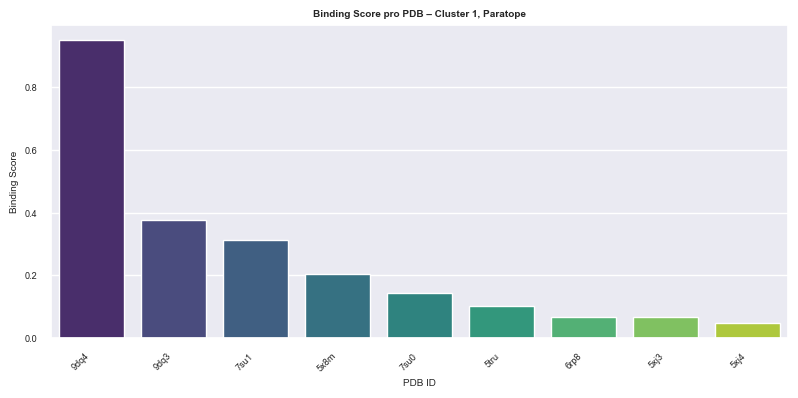

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

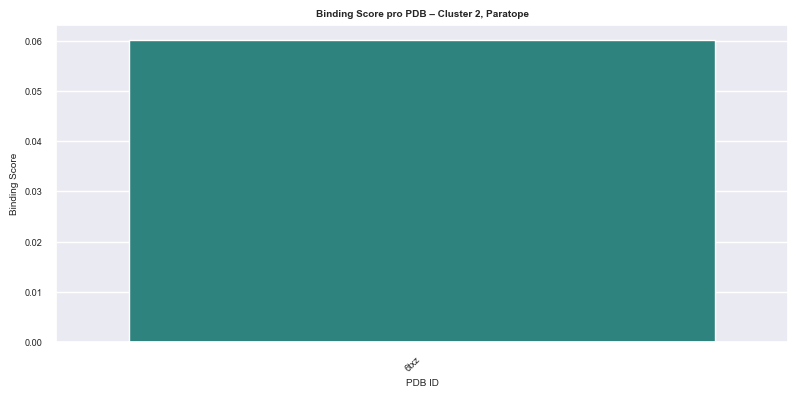

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

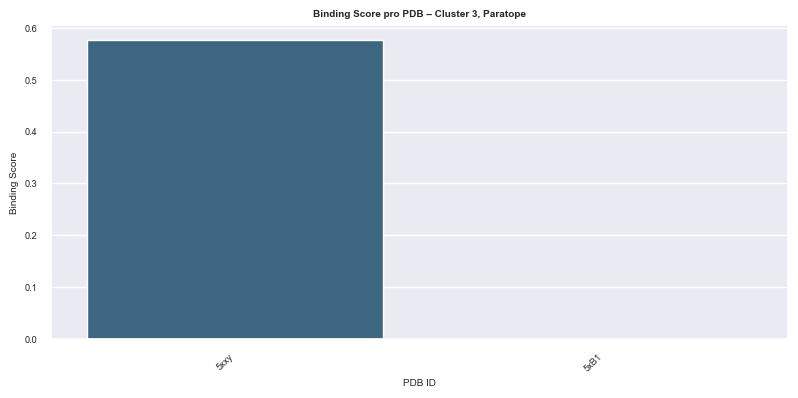

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

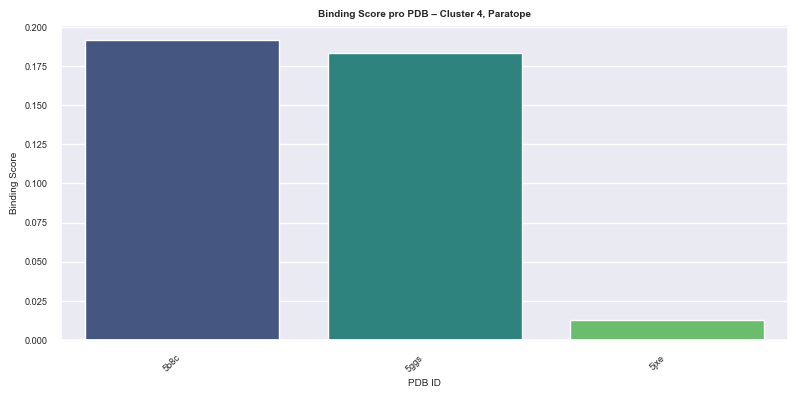

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

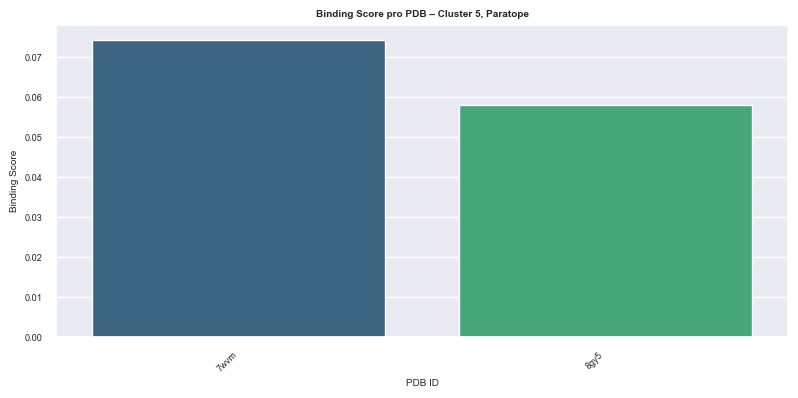

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

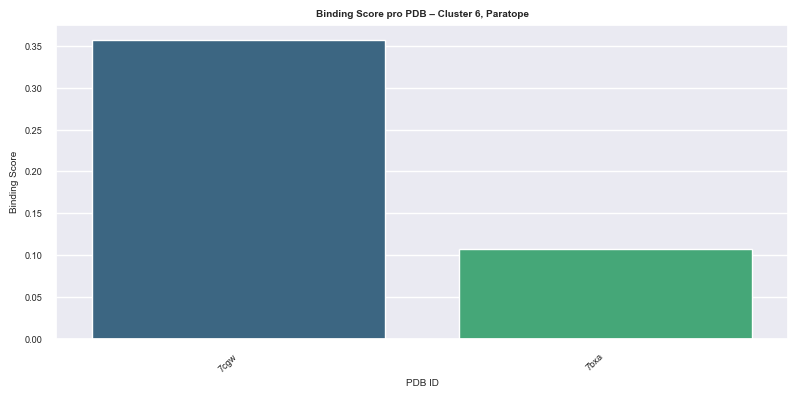

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


<Figure size 640x480 with 0 Axes>

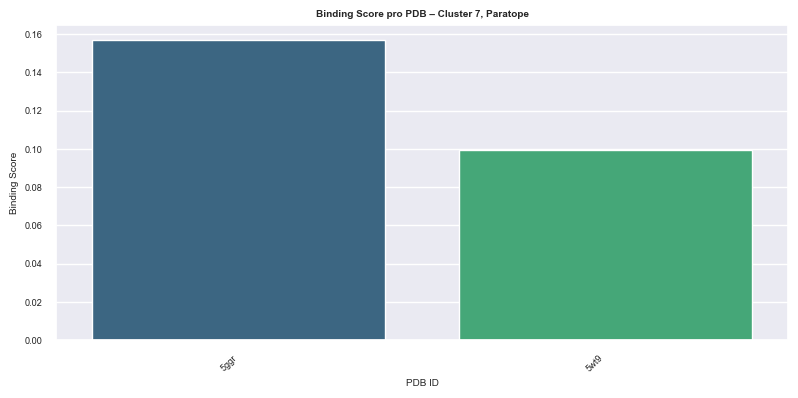

<Figure size 640x480 with 0 Axes>

In [ ]:
clusters = merged_df["cluster"].unique()

# Plot per Cluster
for cluster_name in clusters:
    subset = merged_df[merged_df["cluster"] == cluster_name].sort_values("binding_score", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
    plt.title(f"Binding Score pro PDB – {cluster_name}, {section.capitalize()}")
    plt.xlabel("PDB ID")
    plt.ylabel("Binding Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"plots/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_Binding Score pro PDB – {cluster_name}.pdf", bbox_inches='tight')



/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/2630072359.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])


Mann–Whitney U-Statistik: 64799.00
P-Wert: 0.1847


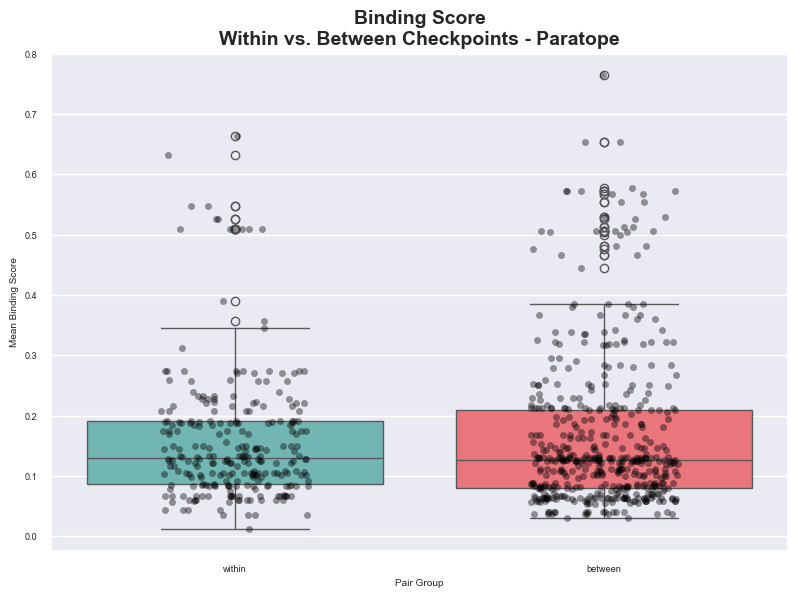

In [ ]:
# Drop NaNs in binding_score or checkpoint 
clean_df = merged_df.dropna(subset=["binding_score", "checkpoint"])

# Generate all pairwise combinations
pairs = []
for (p1, row1), (p2, row2) in combinations(clean_df.iterrows(), 2):
    score1 = row1["binding_score"]
    score2 = row2["binding_score"]

    if pd.notna(score1) and pd.notna(score2):
        pairs.append({
            "pdb_1": row1["pdb_id"],
            "pdb_2": row2["pdb_id"],
            "mean_binding": (score1 + score2) / 2,
            "same_checkpoint": row1["checkpoint"] == row2["checkpoint"]
        })

# Create DataFrame and group labels
df_binding_pairs = pd.DataFrame(pairs)
df_binding_pairs = df_binding_pairs.dropna(subset=["mean_binding"])
df_binding_pairs["group"] = df_binding_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Statistical test
within = df_binding_pairs[df_binding_pairs["group"] == "within"]["mean_binding"]
between = df_binding_pairs[df_binding_pairs["group"] == "between"]["mean_binding"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_binding_pairs, x="group", y="mean_binding", color='black', alpha=0.4, jitter=0.2)

plt.title(f"Binding Score\nWithin vs. Between Checkpoints - {section.capitalize()}", fontsize=14)
plt.ylabel("Mean Binding Score")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [ ]:
df_identity.index = df_identity.index.str.lower()
df_identity.columns = df_identity.columns.str.lower()
merged_df["pdb_id"] = merged_df["pdb_id"].str.lower()
print(df_identity)

                   ctla-4 | 5tru_id1  ctla-4 | 6rp8_id1  ctla-4 | 6rp8_id2  \
ctla-4 | 5tru_id1             100.00              85.71              77.78   
ctla-4 | 6rp8_id1              85.71             100.00              77.78   
ctla-4 | 6rp8_id2              77.78              77.78             100.00   
ctla-4 | 5xj3_id1              57.14              57.14              55.56   
ctla-4 | 5xj3_id2              71.43              71.43              66.67   
ctla-4 | 5xj3_id3              85.71              85.71              77.78   
ctla-4 | 9dq4                  38.46              30.77              38.46   
ctla-4 | 5tru_id2              55.56              55.56              77.78   
ctla-4 | 5xj3_id4              85.71              71.43              66.67   
ctla-4 | 5ggv                  44.44              44.44              44.44   
ctla-4 | 9dq3                  55.56              44.44              55.56   
ctla-4 | 7su1                  71.43              57.14         

In [ ]:
pairs = []

# Extrahiere nur die echten PDB-IDs aus dem df_identity-Index
# Annahme: Format ist "checkpoint | pdb_id"
df_identity.index = df_identity.index.str.extract(r"\|\s*(.*)")[0]
df_identity.columns = df_identity.columns.str.extract(r"\|\s*(.*)")[0]

# Iteriere über alle PDB-Paare
for pdb1, pdb2 in combinations(df_identity.index, 2):
    if pdb1 not in merged_df["pdb_id"].values or pdb2 not in merged_df["pdb_id"].values:
        continue  # Wenn einer fehlt, skip
    
    identity = df_identity.loc[pdb1, pdb2]
    
    # Hole die Checkpoints
    cp1 = merged_df[merged_df["pdb_id"] == pdb1]["checkpoint"]
    cp2 = merged_df[merged_df["pdb_id"] == pdb2]["checkpoint"]
    
    if cp1.empty or cp2.empty:
        continue
    
    group1 = cp1.values[0]
    group2 = cp2.values[0]
    same_group = group1 == group2

    pairs.append({
        "pdb1": pdb1,
        "pdb2": pdb2,
        "identity": identity,
        "same_checkpoint": same_group
    })

# Speichern in DataFrame
df_pairs = pd.DataFrame(pairs)

In [ ]:
from scipy.stats import mannwhitneyu

within = df_pairs[df_pairs["same_checkpoint"] == True]["identity"]
between = df_pairs[df_pairs["same_checkpoint"] == False]["identity"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")


Mann–Whitney U-Statistik: 64.00
P-Wert: 0.0740


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_95025/981194170.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])


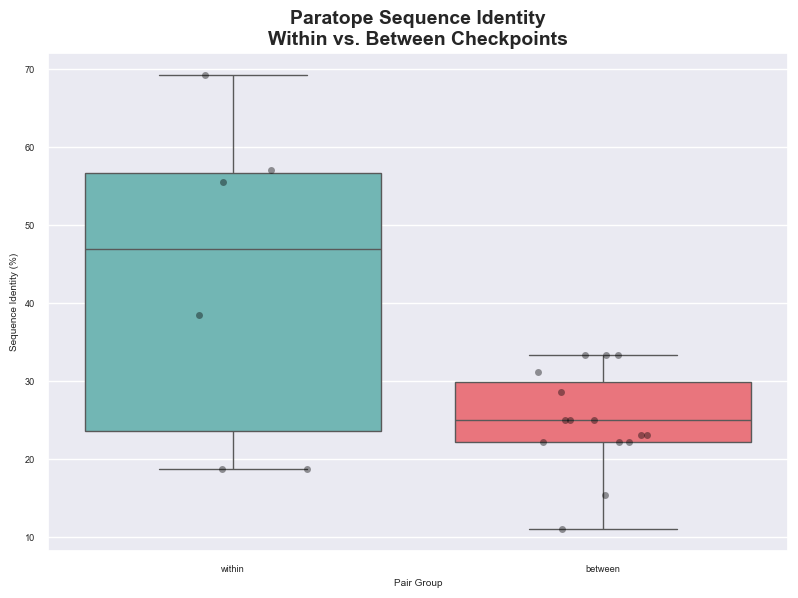

In [ ]:
# Falls noch nicht vorhanden: 'same_checkpoint' als bool-Typ sichern
df_pairs["same_checkpoint"] = df_pairs["same_checkpoint"].astype(bool)

# Ersetze True/False durch beschreibende Labels
df_pairs["group"] = df_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_pairs, x="group", y="identity", color='black', alpha=0.4, jitter=0.2)
plt.title(f"{section.capitalize()} Sequence Identity\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Sequence Identity (%)")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [ ]:
wanted_best_pdbs = ['5xj4', '5x8m', '7bxa', '7cgw', '5b8c', '5ggs', '5jxe', '5x8l',
       '5xxy', '5wt9', '5ggr']

filtered_best_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

filtered_best_df.to_csv(f'data/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_filtered_pdbs_best.csv', index=False)

In [ ]:
wanted_worst_pdbs = ['7wsl', '7wvm', '8gy5', '5grj', '6rp8', '5xj3', '9dq4', '7su0',
       '5tru', '7su1', '9dq3']

filtered_worst_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

filtered_worst_df.to_csv(f'data/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_filtered_pdbs_worst.csv', index=False)

In [ ]:
all_df